In [4]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text as sk_text
from sklearn import svm as sk_svm
from sklearn import preprocessing as sk_preprocessing
from sklearn import model_selection as sk_model_selection
from sklearn import metrics as sk_metrics

# Prepare data

In [5]:
seed = 42

random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)

In [12]:
words = [
    'кінь', 'зебра', 'корова', 'ведмідь', 'олень', 
    'страус', 'курка', 'пінгвін', 'сова', 'лебідь', 
    'морквина', 'яблуко', 'банан', 'картопля', 'лимон'
]

In [13]:
data = pd.read_csv('../resources/data/index.csv', index_col=0)
print(data.shape)
data.head()

(165, 3)


,user,word,description
0,4,кінь,"Парнокопитна тварина, яка була однією з перших..."
1,4,зебра,"африканська тварина, зовнішній вигляд якої наг..."
2,4,корова,"вид парнокопитної худоби, основне використання..."
3,4,ведмідь,"всеїдна велика тварина, яка має дуже сильний т..."
4,4,олень,"парнокопитна дика тварина, яка зазвичай прожив..."


In [14]:
# data_aug = pd.read_csv('../resources/data/data_augment_ua_en_cn_en_ua.csv', index_col=0)
# data_aug['augment'] = 'ua_en_cn_en_ua'
# print(data_aug.shape)
# data_aug.head()
# data = pd.concat([data, data_aug])
# print(data.shape)

In [15]:
data['description'] = data['description'].str.lower()
data['description'] = data['description'].str.replace("’", "'")
# data['descr'] = data['descr'].str.replace("'", '')

In [16]:
train_data = data[data['user'] <= 7].copy()
test_data = data[data['user'] > 7].copy()

In [19]:
feature_extraction = sk_text.TfidfVectorizer()

def get_X_y(data, train=True):
    if train:
        X = feature_extraction.fit_transform(
            data["description"].values
        )
    else:
        X = feature_extraction.transform(
            data["description"].values
        )
    X = X.toarray()
    y = data['word'].apply(lambda x: words.index(x))
    return X, y

In [20]:
X_train, y_train = get_X_y(train_data, 1)
X_test, y_test = get_X_y(test_data, 0)

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((105, 570), (105,), (60, 570), (60,))

# Model selection

In [22]:
params_linear = {
    'C': [0.01, 0.1, 1.],
}
params_poly = {
    'C': [0.01, 0.1, 1.],
    'degree': [2, 3],
    'gamma': ['scale', 'auto'],
}
params_rbf = {
    'C': [0.01, 0.1, 1.],
    'gamma': ['scale', 'auto'],
}
params_sigmoid = {
    'C': [0.01, 0.1, 1.],
    'gamma': ['scale', 'auto'],
}

In [35]:
def cv_model(name, model, params, X_train, y_train, X_test, y_test):
    cv_model = sk_model_selection.GridSearchCV(
        model, 
        params, 
        cv=3,
        scoring='accuracy',
    )
    cv_model.fit(X_train, y_train)
    print(cv_model.best_params_)
    print(name, sk_metrics.accuracy_score(y_test, cv_model.predict(X_test)))

def create_models(X_train, y_train, X_test, y_test):
    linear_svc_model = sk_svm.SVC(
        kernel='linear', 
        random_state=seed
    )
    cv_model('linear', linear_svc_model, params_linear, X_train, y_train, X_test, y_test)
    
    poly_svc_model = sk_svm.SVC(
        kernel='poly', 
        random_state=seed
    )
    cv_model('poly', poly_svc_model, params_poly, X_train, y_train, X_test, y_test)
    
    rbf_svc_model = sk_svm.SVC(
        kernel='rbf', 
        random_state=seed
    )
    cv_model('rbf', rbf_svc_model, params_rbf, X_train, y_train, X_test, y_test)
    
    sigmoid_svc_model = sk_svm.SVC(
        kernel='sigmoid', 
        random_state=seed
    )
    cv_model('sigmoid', sigmoid_svc_model, params_sigmoid, X_train, y_train, X_test, y_test)

In [36]:
create_models(X_train, y_train, X_test, y_test)

{'C': 1.0}
linear 0.7833333333333333
{'C': 1.0, 'degree': 2, 'gamma': 'scale'}
poly 0.8
{'C': 0.01, 'gamma': 'auto'}
rbf 0.7833333333333333
{'C': 1.0, 'gamma': 'scale'}
sigmoid 0.7666666666666667


In [40]:
model = sk_svm.SVC(
    kernel='poly', 
    C=1.0, 
    degree=2, 
    gamma='scale', 
    probability=True,
    random_state=seed,
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
sk_metrics.accuracy_score(y_test, predictions)

0.8

In [41]:
y_test.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int64)

In [42]:
predictions

array([ 0,  1,  3, 13, 13,  5,  6,  7,  8,  9, 10, 11, 10, 10, 12,  0,  1,
        2,  3,  4,  5,  6,  1,  8,  9, 10, 11, 12, 10, 14,  0,  1,  0,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  0,  1,  2,  5,  4,  6,
        6,  7,  8,  5, 10, 11, 12, 13, 14], dtype=int64)

In [43]:
m = sk_metrics.confusion_matrix(y_test, predictions)

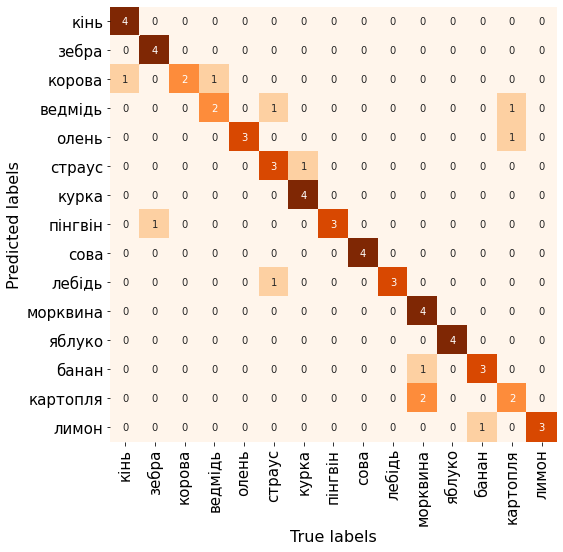

In [45]:
df_cm = pd.DataFrame(m, index=words, columns=words)
plt.figure(figsize=(8, 8))
sns.heatmap(df_cm, annot=True, cbar=False, cmap='Oranges')
plt.xlabel('True labels', fontsize=16)
plt.xticks(fontsize=15)
plt.ylabel('Predicted labels', fontsize=16)
plt.yticks(fontsize=15);

In [46]:
mm = []
for i in range(3):
    mm.append([])
    for j in range(3):
        mm[-1].append(np.sum(m[5*i:5*(i+1), 5*j:5*(j+1)]))
mm

[[17, 1, 2], [1, 19, 0], [0, 0, 20]]

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Тварини'), Text(0, 1.5, 'Птахи'), Text(0, 2.5, 'Їжа')])

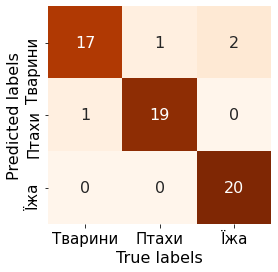

In [48]:
q = pd.DataFrame(mm, index = ['Тварини', 'Птахи', 'Їжа'], columns = ['Тварини', 'Птахи', 'Їжа'])
plt.figure(figsize = (4,4))
sns.heatmap(q, annot=True, cbar=False, cmap='Oranges', annot_kws={"size": 16})
plt.xlabel('True labels', fontsize=16)
plt.xticks(fontsize=15)
plt.ylabel('Predicted labels', fontsize=16)
plt.yticks(fontsize=15)

In [49]:
test_data['pred'] = predictions
test_data['real'] = y_test

In [51]:
no_ok = test_data[test_data['pred'] != test_data['real']]
for i in range(no_ok.shape[0]):
    print(no_ok.iloc[i]['description'], '|', no_ok.iloc[i]['word'], '|', words[no_ok.iloc[i]['pred']])

велика, рогата худоба. | корова | ведмідь
впадає в сплячку взимку, любить мед. | ведмідь | картопля
цим звіром нарікають людей, які чогось не розуміють. | олень | картопля
подовгуватий фрукт, який їдять в очищеному вигляді, без шкірки. | банан | морквина
овоч, який споживають більшість людей, особливо в смаженому вигляді. | картопля | морквина
жовтий, овальний на вигляд фрукт. | лимон | банан
чорно-біла птиця, живе на південному полюсі | пінгвін | зебра
традиційний овоч білорусії | картопля | морквина
велика тварина, яку тримають для отримання молока. має біле забарвлення з чорними плямами. | корова | кінь
великий хижий ссавець тварина з довгою шерстю і товстими ногами. | ведмідь | страус
найбільший бігучий (нелетючий) птах жарких країн з красивим оперенням. | страус | курка
велика водоплавна птиця з довгою зігнутою шиєю. | лебідь | страус


In [26]:
# import pickle

# pickle.dump(feature_extraction, open('../resources/models/tfidf_model', 'wb'))
# pickle.dump(model, open('../resources/models/svc_model', 'wb'))